In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and preprocess data
df = pd.read_csv('city_day.csv')
df['Date'] = pd.to_datetime(df['Date'])

# Fill missing values
numeric_columns = df.select_dtypes(include=[np.number]).columns
for column in numeric_columns:
    df[column].fillna(df[column].mean(), inplace=True)

# Create features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

# Prepare features for deep learning
features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3',
           'Benzene', 'Toluene', 'Xylene', 'Month', 'Day']
X = df[features].values
y = df['AQI'].values

# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [3]:
# Create sequences for time series models
def create_sequences(X, y, sequence_length):
    Xs, ys = [], []
    for i in range(len(X) - sequence_length):
        Xs.append(X[i:(i + sequence_length)])
        ys.append(y[i + sequence_length])
    return np.array(Xs), np.array(ys)

sequence_length = 30
X_seq, y_seq = create_sequences(X_scaled, y_scaled, sequence_length)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [4]:
# model development
# 1. LSTM Model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(32),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    return model

# 2. CNN-LSTM Hybrid Model
def create_cnn_lstm_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(32, return_sequences=True),
        LSTM(16),
        Dense(1)
    ])
    return model

# 3. Transformer Model
def create_transformer_model(input_shape):
    inputs = Input(shape=input_shape)

    # Multi-Head Attention Layer
    attention_output = MultiHeadAttention(
        num_heads=4, key_dim=32
    )(inputs, inputs)

    # Add & Normalize
    x = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    # Feed Forward Network
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)

    # Add & Normalize
    x = LayerNormalization(epsilon=1e-6)(x)

    # Output layers
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)

    return Model(inputs=inputs, outputs=outputs)

In [5]:
# Initialize models
lstm_model = create_lstm_model((sequence_length, X.shape[1]))
cnn_lstm_model = create_cnn_lstm_model((sequence_length, X.shape[1]))
transformer_model = create_transformer_model((sequence_length, X.shape[1]))

# Compile models
models = [lstm_model, cnn_lstm_model, transformer_model]
model_names = ['LSTM', 'CNN-LSTM', 'Transformer']

for model in models:
    model.compile(optimizer='adam', loss='mse')

# Train and evaluate models
results = {}
history_dict = {}

for model, name in zip(models, model_names):
    print(f"\nTraining {name} model...")
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=50,
        validation_split=0.2,
        verbose=1
    )
    history_dict[name] = history.history

    # Predictions
    y_pred = model.predict(X_test)

    # Inverse transform predictions
    y_test_inv = scaler_y.inverse_transform(y_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred)

    # Calculate metrics
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)

    results[name] = {'MSE': mse, 'R2': r2}


Training LSTM model...
Epoch 1/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 2/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 3/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 4/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 0.0010 - val_loss: 9.4048e-04
Epoch 6/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 8.3953e-04 - val_loss: 0.0011
Epoch 7/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - loss: 9.7649e-04 - val_loss: 0.0011
Epoch 8/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 8.4438e-04 - val_loss: 9.0326e-04
Epoch 9/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 8.7046e-04 - val_loss: 0.0010
Epoch 10/10
378/378 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 7.7669e-04 - val_loss: 9.4385e-04
185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Training CNN-LSTM mo

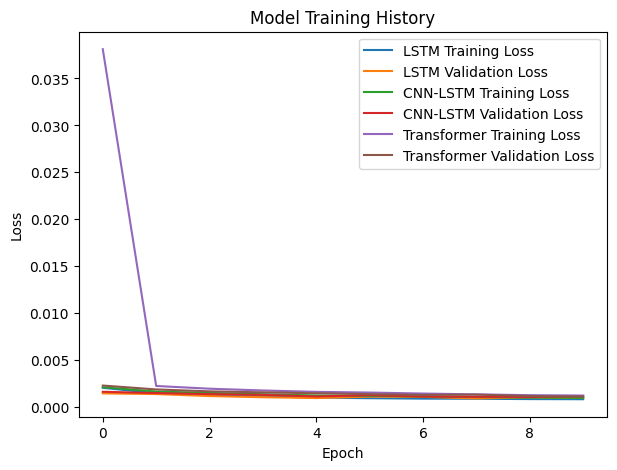

In [80]:
# Visualize results
plt.figure(figsize=(15, 5))

# Plot training history
plt.subplot(1, 2, 1)
for name in model_names:
    plt.plot(history_dict[name]['loss'], label=f'{name} Training Loss')
    plt.plot(history_dict[name]['val_loss'], label=f'{name} Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

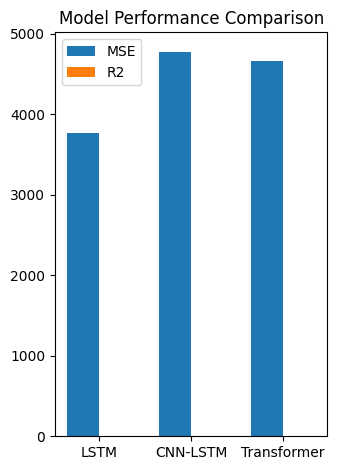

In [81]:
# Plot model comparison
plt.subplot(1, 2, 2)
mse_scores = [results[name]['MSE'] for name in model_names]
r2_scores = [results[name]['R2'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

plt.bar(x - width/2, mse_scores, width, label='MSE')
plt.bar(x + width/2, r2_scores, width, label='R2')
plt.xticks(x, model_names)
plt.title('Model Performance Comparison')
plt.legend()

plt.tight_layout()
plt.show()

In [82]:
# Print detailed results
print("\nModel Performance Results:")
for name in model_names:
    print(f"\n{name} Model:")
    print(f"Mean Squared Error: {results[name]['MSE']:.4f}")
    print(f"R-squared Score: {results[name]['R2']:.4f}")

# Save the best model
best_model_name = min(results, key=lambda k: results[k]['MSE'])
best_model = models[model_names.index(best_model_name)]
best_model.save(f'best_aqi_prediction_model.h5')
print(f"\nBest performing model ({best_model_name}) has been saved.")


Model Performance Results:

LSTM Model:
Mean Squared Error: 3761.8429
R-squared Score: 0.7824

CNN-LSTM Model:
Mean Squared Error: 4776.4351
R-squared Score: 0.7237

Transformer Model:
Mean Squared Error: 4653.2798
R-squared Score: 0.7308

Best performing model (LSTM) has been saved.


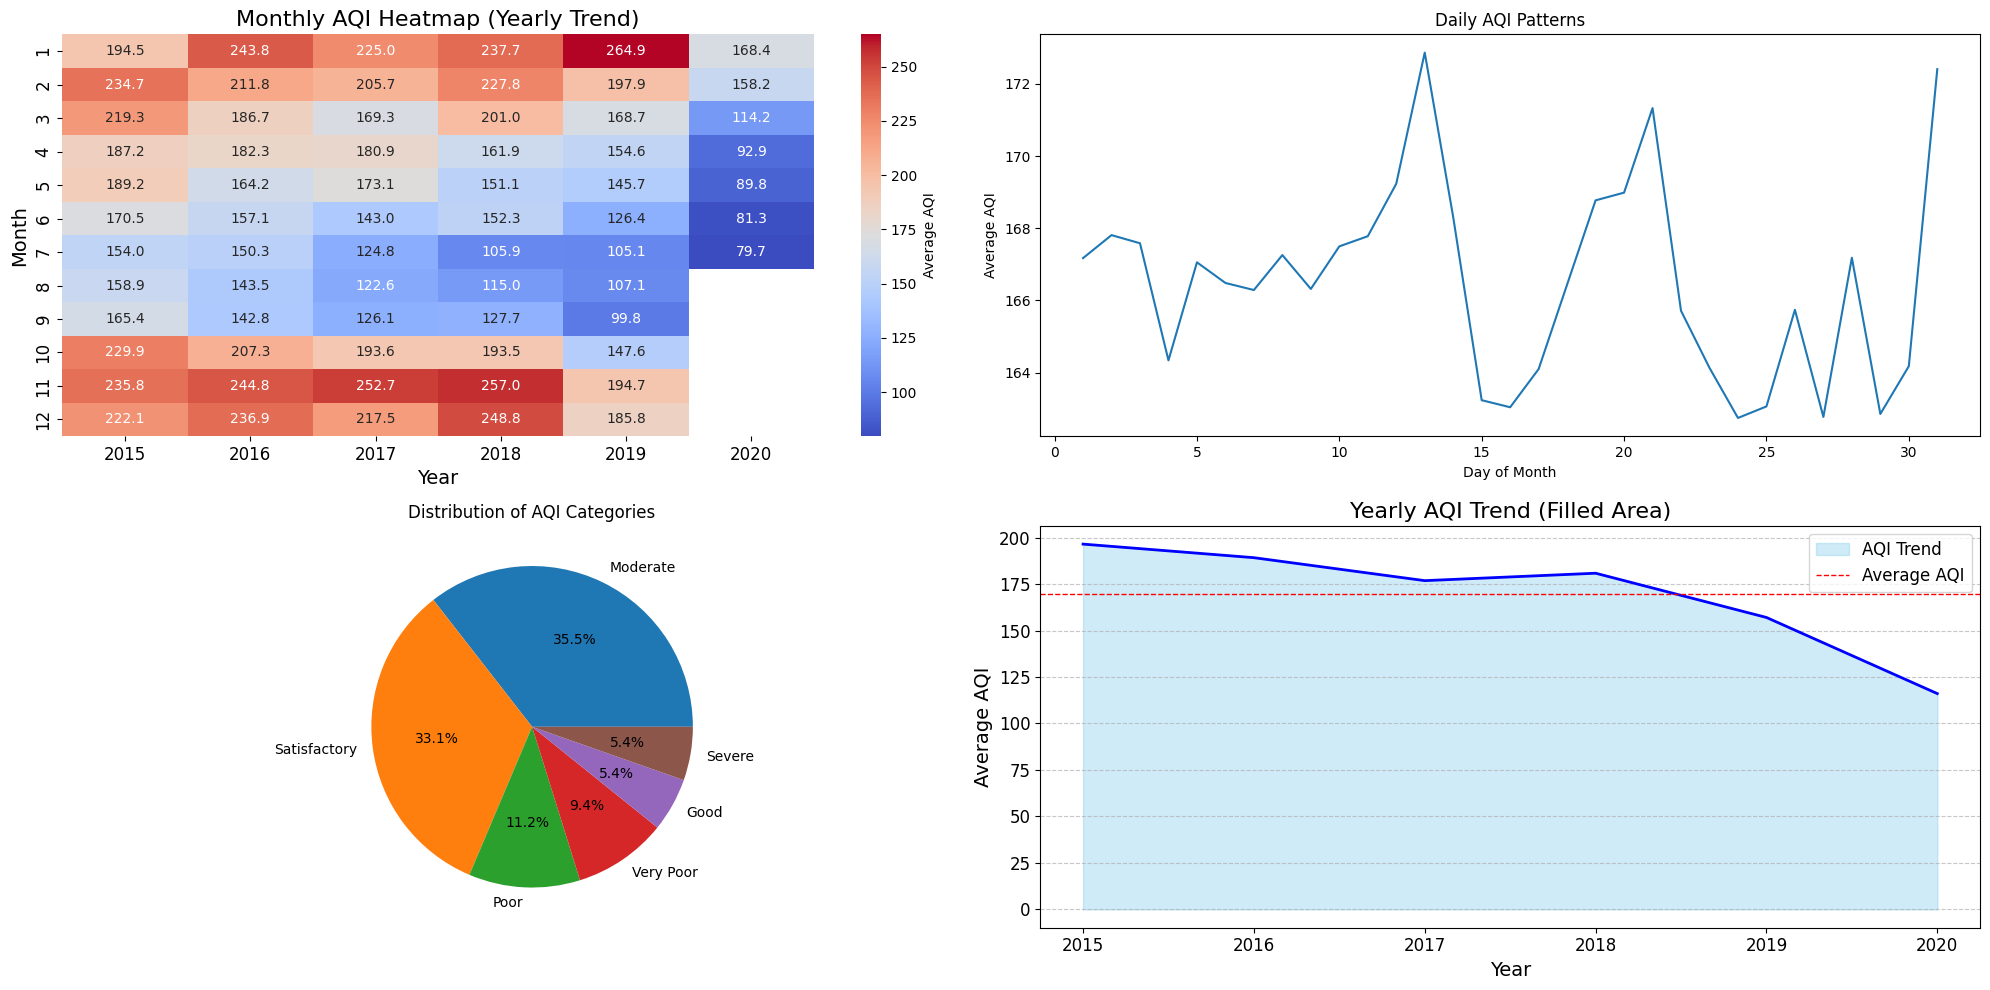

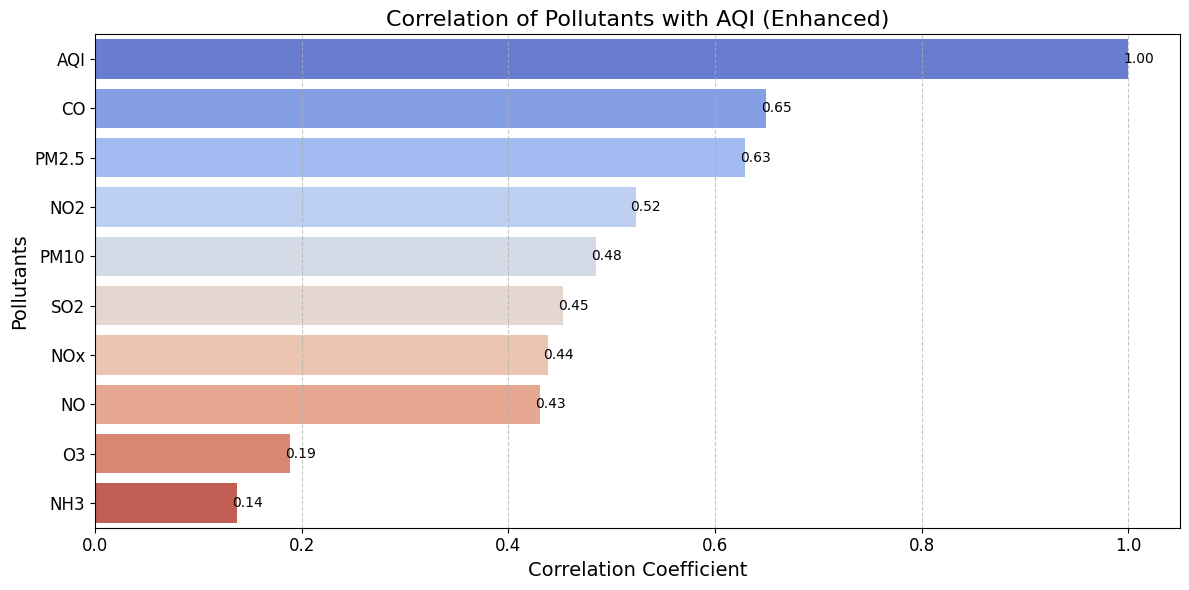

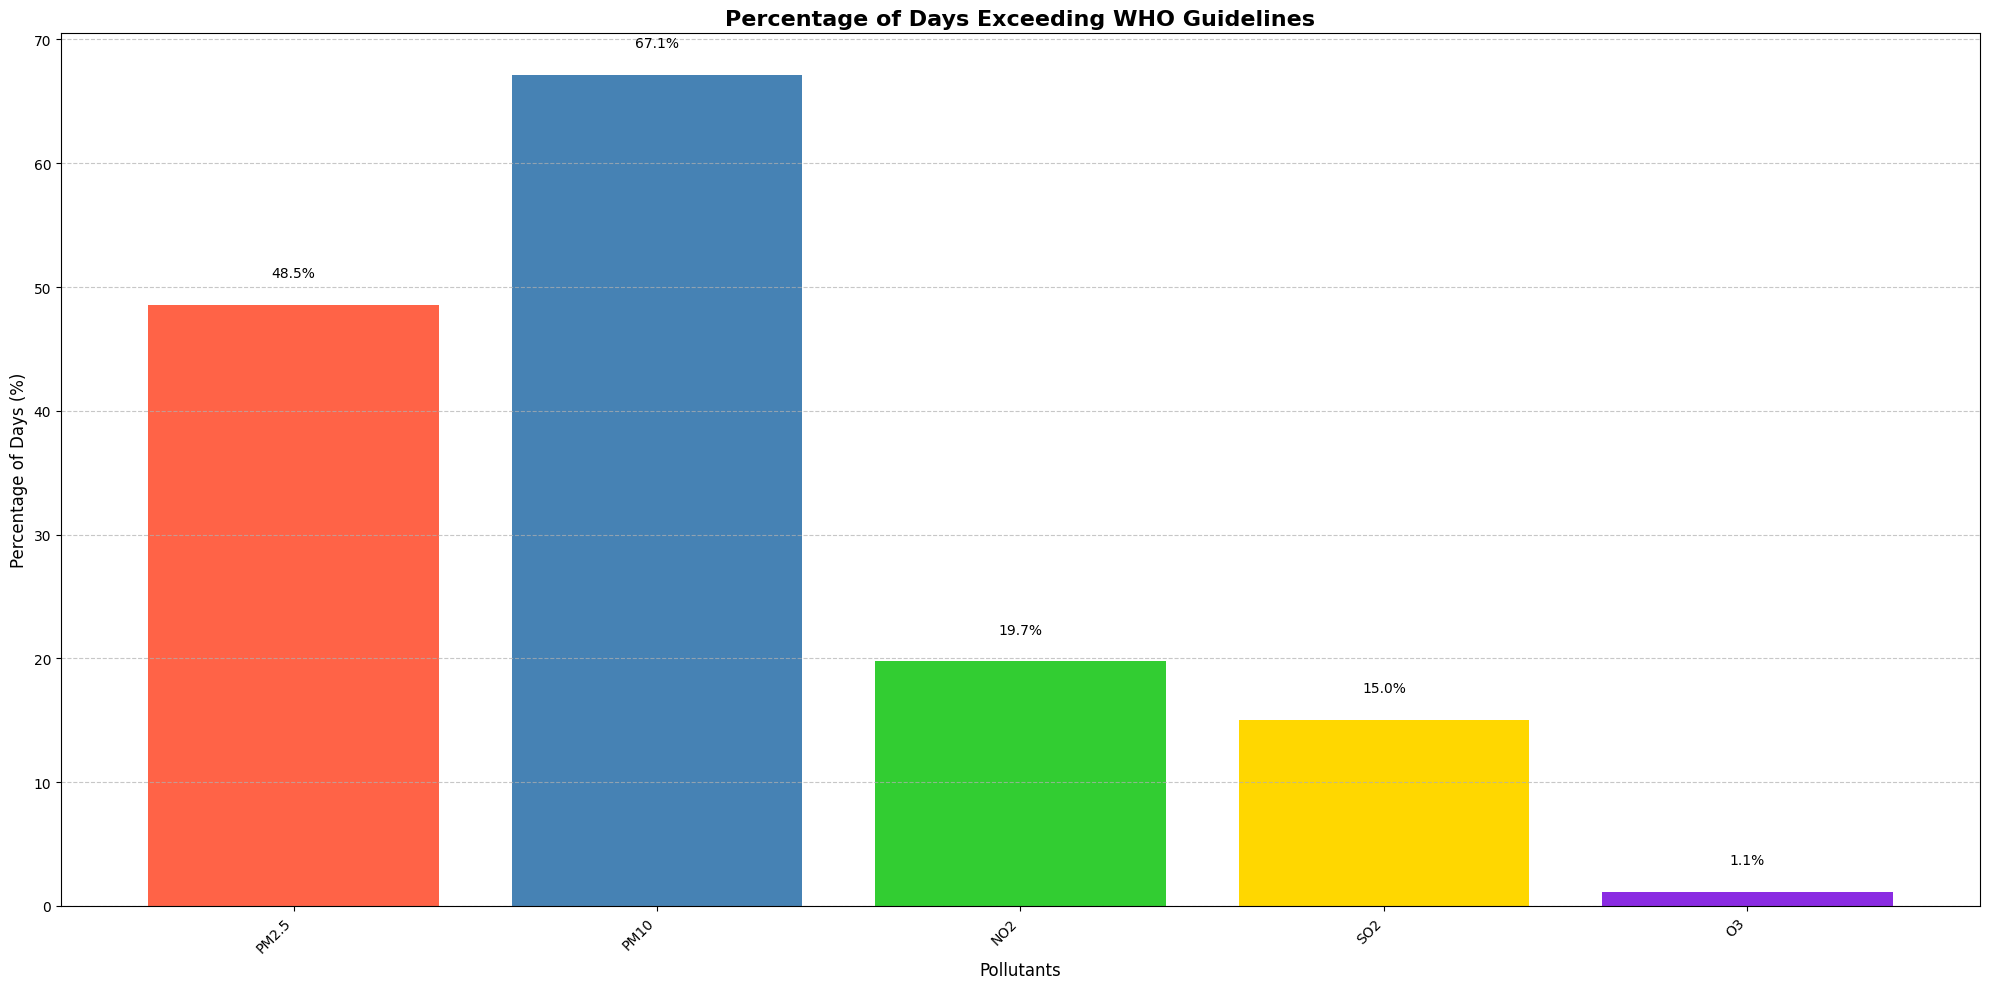

In [83]:
# Additional Analysis and Key Findings

# 1. Temporal Pattern Analysis
plt.figure(figsize=(20, 10))

# Monthly AQI Patterns
plt.subplot(2, 2, 1)
heatmap_data = df.groupby(['Month', 'Year'])['AQI'].mean().unstack()
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".1f", cbar_kws={'label': 'Average AQI'})

plt.title('Monthly AQI Heatmap (Yearly Trend)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Month', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


# Daily AQI Patterns
plt.subplot(2, 2, 2)
daily_aqi = df.groupby('Day')['AQI'].mean()
sns.lineplot(x=daily_aqi.index, y=daily_aqi.values)
plt.title('Daily AQI Patterns')
plt.xlabel('Day of Month')
plt.ylabel('Average AQI')


# AQI Categories Distribution
plt.subplot(2, 2, 3)
aqi_categories = df['AQI_Bucket'].value_counts()
plt.pie(aqi_categories.values, labels=aqi_categories.index, autopct='%1.1f%%')
plt.title('Distribution of AQI Categories')


# Yearly Trend (Filled Area Chart)
plt.subplot(2, 2, 4)
yearly_aqi = df.groupby('Year')['AQI'].mean()
plt.fill_between(yearly_aqi.index, yearly_aqi.values, color='skyblue', alpha=0.4, label='AQI Trend')
plt.plot(yearly_aqi.index, yearly_aqi.values, color='blue', linewidth=2)

plt.title('Yearly AQI Trend (Filled Area)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Average AQI', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(yearly_aqi.mean(), color='red', linestyle='--', linewidth=1, label='Average AQI')
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# 2. Pollutant Contribution Analysis
pollutants = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

# Calculate the correlation with AQI
pollutant_correlation = df[pollutants + ['AQI']].corr()['AQI'].sort_values(ascending=False)

plt.figure(figsize=(12, 6))
colors = sns.color_palette("coolwarm", len(pollutant_correlation))
sns.barplot(y=pollutant_correlation.index, x=pollutant_correlation.values, palette=colors)
plt.title('Correlation of Pollutants with AQI (Enhanced)', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=14)
plt.ylabel('Pollutants', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='x', linestyle='--', alpha=0.7)
for i, value in enumerate(pollutant_correlation.values):
    plt.text(value + 0.01 if value > 0 else value - 0.05, i, f"{value:.2f}",
             ha='center' if value > 0 else 'right', va='center', fontsize=10)
plt.tight_layout()
plt.show()


# 3. Critical Threshold Analysis
def analyze_threshold_exceedance(df):
    thresholds = {
        'PM2.5': 60,  # WHO guideline
        'PM10': 100,  # WHO guideline
        'NO2': 40,    # WHO guideline
        'SO2': 20,    # WHO guideline
        'O3': 100     # WHO guideline
    }

    exceedance_data = {}
    for pollutant, threshold in thresholds.items():
        if pollutant in df.columns:
            exceedance_data[pollutant] = (df[pollutant] > threshold).mean() * 100

    return exceedance_data

exceedance_results = analyze_threshold_exceedance(df)

plt.figure(figsize=(20, 10))
bars = plt.bar(exceedance_results.keys(), exceedance_results.values(), color=['#FF6347', '#4682B4', '#32CD32', '#FFD700', '#8A2BE2'])
plt.grid(axis='y',linestyle='--', alpha=0.7)

plt.title('Percentage of Days Exceeding WHO Guidelines', fontsize=16, fontweight='bold')
plt.ylabel('Percentage of Days (%)', fontsize=12)
plt.xlabel('Pollutants', fontsize=12)
plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f'{yval:.1f}%', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()


185/185 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


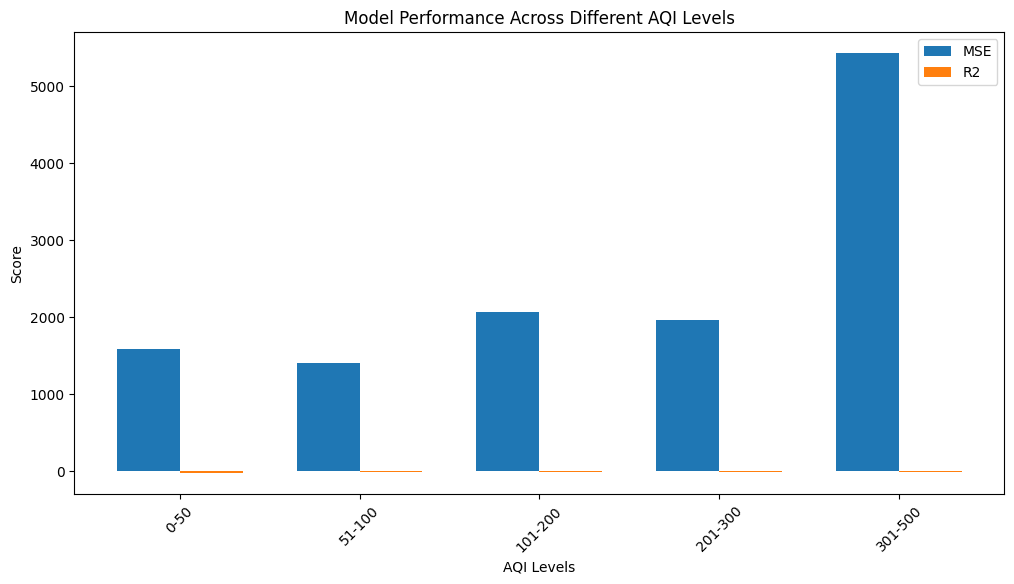

In [87]:
# 4. Model Performance Analysis for Different AQI Levels
def analyze_model_performance_by_aqi_level(y_true, y_pred, aqi_levels):
    performance_by_level = {}
    for level in aqi_levels:
        mask = (y_true >= level[0]) & (y_true < level[1])
        if mask.any():
            mse = mean_squared_error(y_true[mask], y_pred[mask])
            r2 = r2_score(y_true[mask], y_pred[mask])
            performance_by_level[f'{level[0]}-{level[1]}'] = {'MSE': mse, 'R2': r2}
    return performance_by_level

# Define AQI levels
aqi_levels = [(0, 50), (51, 100), (101, 200), (201, 300), (301, 500)]

# Calculate performance for best model
best_model_predictions = best_model.predict(X_test)
best_model_predictions = scaler_y.inverse_transform(best_model_predictions)
y_test_actual = scaler_y.inverse_transform(y_test)

level_performance = analyze_model_performance_by_aqi_level(
    y_test_actual.flatten(),
    best_model_predictions.flatten(),
    aqi_levels
)

# Visualize performance by AQI level
plt.figure(figsize=(12, 6))
levels = list(level_performance.keys())
mse_scores = [level_performance[level]['MSE'] for level in levels]
r2_scores = [level_performance[level]['R2'] for level in levels]

x = np.arange(len(levels))
width = 0.35

plt.bar(x - width/2, mse_scores, width, label='MSE')
plt.bar(x + width/2, r2_scores, width, label='R2')
plt.xlabel('AQI Levels')
plt.ylabel('Score')
plt.title('Model Performance Across Different AQI Levels')
plt.xticks(x, levels, rotation=45)
plt.legend()
plt.show()

In [88]:
# 5. Generate Key Findings Report
print("\nKEY FINDINGS REPORT")
print("=" * 50)

print("\n1. Temporal Patterns:")
print(f"- Highest average AQI occurs in month {monthly_aqi.idxmax()} ({monthly_aqi.max():.2f})")
print(f"- Lowest average AQI occurs in month {monthly_aqi.idxmin()} ({monthly_aqi.min():.2f})")
print(f"- Year-over-year trend shows {'an increase' if yearly_aqi.iloc[-1] > yearly_aqi.iloc[0] else 'a decrease'} in AQI")

print("\n2. Pollutant Impact:")
print("Most influential pollutants (by correlation with AQI):")
for pollutant, corr in pollutant_correlation.items():
    if pollutant != 'AQI':
        print(f"- {pollutant}: {corr:.3f}")

print("\n3. Health Implications:")
print("WHO Guideline Exceedance:")
for pollutant, percentage in exceedance_results.items():
    print(f"- {pollutant}: {percentage:.1f}% of days exceed guidelines")

print("\n4. Model Performance Summary:")
print(f"Best performing model: {best_model_name}")
print("Performance across AQI levels:")
for level, metrics in level_performance.items():
    print(f"- AQI {level}: MSE = {metrics['MSE']:.2f}, R² = {metrics['R2']:.2f}")

print("\n5. Recommendations for Urban Planning:")
high_risk_months = monthly_aqi[monthly_aqi > monthly_aqi.mean()].index.tolist()
print(f"- Critical months for air quality management: {', '.join(map(str, high_risk_months))}")
print("- Focus areas for emission control:")
for pollutant, corr in pollutant_correlation.items():
    if pollutant != 'AQI' and abs(corr) > 0.5:
        print(f"  * {pollutant} (correlation: {corr:.3f})")




KEY FINDINGS REPORT

1. Temporal Patterns:
- Highest average AQI occurs in month 11 (232.63)
- Lowest average AQI occurs in month 7 (120.81)
- Year-over-year trend shows a decrease in AQI

2. Pollutant Impact:
Most influential pollutants (by correlation with AQI):
- CO: 0.650
- PM2.5: 0.629
- NO2: 0.523
- PM10: 0.484
- SO2: 0.453
- NOx: 0.438
- NO: 0.431
- O3: 0.189
- NH3: 0.137

3. Health Implications:
WHO Guideline Exceedance:
- PM2.5: 48.5% of days exceed guidelines
- PM10: 67.1% of days exceed guidelines
- NO2: 19.7% of days exceed guidelines
- SO2: 15.0% of days exceed guidelines
- O3: 1.1% of days exceed guidelines

4. Model Performance Summary:
Best performing model: LSTM
Performance across AQI levels:
- AQI 0-50: MSE = 1590.10, R² = -20.84
- AQI 51-100: MSE = 1402.84, R² = -6.82
- AQI 101-200: MSE = 2073.13, R² = -1.99
- AQI 201-300: MSE = 1961.59, R² = -1.61
- AQI 301-500: MSE = 5425.42, R² = -1.12

5. Recommendations for Urban Planning:
- Critical months for air quality mana

In [91]:
# 6. Save findings to a file
with open('air_quality_analysis_findings.txt', 'w') as f:
    f.write("AIR QUALITY ANALYSIS FINDINGS\n")
    f.write("============================\n\n")
    f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d')}\n\n")

    f.write("1. Model Performance:\n")
    for name in model_names:
        f.write(f"\n{name} Model:\n")
        f.write(f"MSE: {results[name]['MSE']:.4f}\n")
        f.write(f"R²: {results[name]['R2']:.4f}\n")

    f.write("\n2. Temporal Patterns:\n")
    f.write(f"Peak AQI Month: {monthly_aqi.idxmax()}\n")
    f.write(f"Lowest AQI Month: {monthly_aqi.idxmin()}\n")

    f.write("\n3. Critical Pollutants:\n")
    for pollutant, corr in pollutant_correlation.items():
        if pollutant != 'AQI':
            f.write(f"{pollutant}: {corr:.3f}\n")

    f.write("\n4. WHO Guideline Exceedance:\n")
    for pollutant, percentage in exceedance_results.items():
        f.write(f"{pollutant}: {percentage:.1f}%\n")

print("\nDetailed analysis results have been saved to 'air_quality_analysis_findings.txt'")


Detailed analysis results have been saved to 'air_quality_analysis_findings.txt'
